In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
datalib = Path.cwd().parent.joinpath('_data')
import eventstudy as etb
import numpy as np
import pandas_datareader.data as web
import statsmodels.api as sm

import warnings

warnings.filterwarnings('ignore')
#ha módosulnak a fájlok, akkor azt szinkronizáljuk

In [3]:
companies = etb.load_sp500_tickers(datalib)
#lescrapeli a wikipédiáról a tickereket

In [4]:
import datetime
start = datetime.datetime(2021, 1, 1)
end = datetime.datetime(2023, 8, 1)
#mikortól meddig akarunk adatokat, ebben még benne van a hétvége, ünnepnap is
company_data = etb.fetch_data_from_yahoo(companies, start,end)
#lementi helyben, egyesével leszedi az adatokat. Ha újra meghvjuk akkor beolvassa, nem fogja újra letölteni

[*********************100%%**********************]  503 of 503 completed


4 Failed downloads:
['MSCI']: OperationalError('database is locked')
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1609477200, endDate = 1690862400")
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2021-01-01 00:00:00 -> 2023-08-01 00:00:00)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [5]:
market = web.DataReader(['sp500'], 'fred', start, end)
market.dropna(inplace = True)
market['log_return'] = np.log(market.sp500 / market.sp500.shift(1))
market
#ki kéne vonni a kockázatmentes hozamot, logaritmizáltunk 

,sp500,log_return
DATE,,
2021-01-04,3700.65,NaN
2021-01-05,3726.86,0.007058
2021-01-06,3748.14,0.005694
2021-01-07,3803.79,0.014738
2021-01-08,3824.68,0.005477
...,...,...
2023-07-26,4566.75,-0.000155
2023-07-27,4537.41,-0.006445
2023-07-28,4582.23,0.009829


In [6]:
price_column = 'Adj Close'
ticker_column = 'Symbol'
date_column = 'Date'
daily_return = etb.generate_daily_returns_from_price_data(company_data, price_column, ticker_column, date_column)
daily_return = daily_return.join(other=market.log_return, on='Date', how='left')
daily_return
#minden egyes tickerhez kiszámoljuk a napi loghozamokat, egy táblába rakjuk a napi és market hozamokat

,Symbol,Daily Returns,log_return
Date,,,
2021-01-05,A,0.008143,0.007058
2021-01-06,A,0.027053,0.005694
2021-01-07,A,0.026261,0.014738
2021-01-08,A,0.007108,0.005477
2021-01-11,A,0.008542,-0.006576
...,...,...,...
2023-07-25,ZTS,0.024327,0.002811
2023-07-26,ZTS,0.009682,-0.000155
2023-07-27,ZTS,-0.017390,-0.006445


In [7]:
event_date = pd.to_datetime('2023-03-10')
event_window = pd.to_datetime([event_date + pd.offsets.BusinessDay(day) for day in range(-5,6,1)])
estimation_window = pd.to_datetime([event_date + pd.offsets.BusinessDay(day) for day in range(-240,-20,1)])
length_of_estimation_window = estimation_window.shape[0]
length_of_event_window = event_window.shape[0]
#meghatározzuk az esemény napot, eseményablakot -5;5 
#estimation window kiszámolása
#ablakok hossza

In [8]:
train = daily_return[(daily_return.Symbol=='JPM') & (daily_return.index >= estimation_window[0]) & (daily_return.index <= estimation_window[-1])].copy()
#jpm symbol, estimation window első eleme és utolsó eleme közé esik, ezen fogunk becsülni 
#model = sm.OLS(endog=train['Daily Returns'], exog=sm.add_constant(train.log_return)).fit()
#train['expected_return'] = model.params[0] + model.params[1] * train.log_return
#lefuttatjuk a modellt és kiszedjük a paramétereit
train['expected_return'] = train['Daily Returns'].mean()

In [9]:
train['abnormal_return'] = train['Daily Returns'] - train['expected_return']
#abnormális hozam meghatározása

In [10]:
test = daily_return[(daily_return.Symbol=='JPM') & (daily_return.index >= event_window[0]) & (daily_return.index <= event_window[-1])].copy()
test['expected_return'] = train['Daily Returns'].mean()
#test['expected_return'] = model.params[0] + model.params[1] * test.log_return
test['abnormal_return'] = test['Daily Returns'] - test['expected_return']
#train modellen becsült modelleket kivesszük, becsüljük a hozamokat

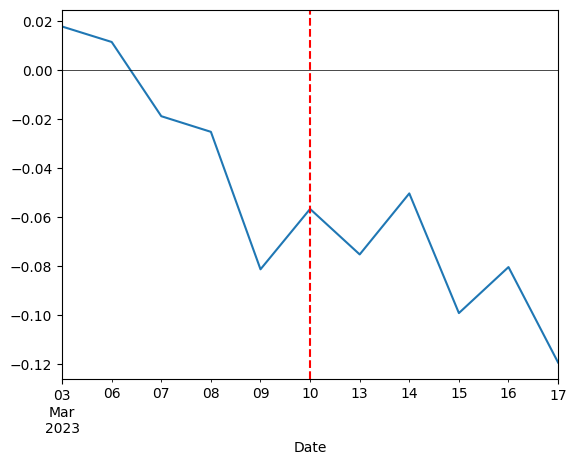

In [11]:
ax = test.abnormal_return.cumsum().plot()
ax.axvline('2023-03-10', color = 'red', linestyle = '--')
ax.axhline(0, color = 'black', linewidth = 0.5)
#van egy lefelé tartó trend, pozitív felugrás van az event dayen. 

In [12]:
sample_variance = np.sum(train.abnormal_return**2) / (length_of_estimation_window - 2)
#variancia számítása, ami kell, 2 a becsült paraméterek száma
t_value_event_date = test.abnormal_return[event_date] / np.sqrt(sample_variance)

t_value_event_window = np.sum(test.abnormal_return[event_window]) / np.sqrt(11 * sample_variance)
#11 napos az event window
f"Event date t-value: {t_value_event_date:.3f}, [-5, 5] event window t-value: {t_value_event_window:.3f}"

'Event date t-value: 1.430, [-5, 5] event window t-value: -2.090'

In [13]:
import scipy.stats as st
cil, ciu = st.t.interval(confidence=0.99, 
              df=len(test.abnormal_return)-1, 
              loc=np.mean(test.abnormal_return),  
              scale=st.sem(test.abnormal_return)) 

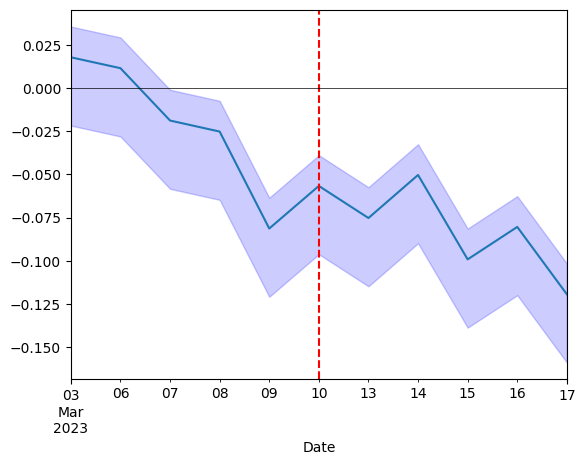

In [14]:
ax = test.abnormal_return.cumsum().plot()
ax.axvline('2023-03-10', color = 'red', linestyle = '--')
ax.axhline(0, color = 'black', linewidth = 0.5)
ax.fill_between(test.index, test.abnormal_return.cumsum() + cil, test.abnormal_return.cumsum() + ciu, color='blue', alpha = 0.2)